# **Plant Seedlings Classification**

## **Problem Definition & Objective**

You are provided with a dataset  of  images of  plant seedlings at various stages of  grown.  Each image has a filename that is its unique  id.  The  dataset  comprises  12  plant  species.  The  goal  of  the  project  is  to  create  a  classifier  capable  of  determining  a plant's species from a photo.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import Pertinent Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential    #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten    # importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers
from keras.preprocessing.image import load_img
from skimage.color import rgb2gray

from google.colab.patches import cv2_imshow
from PIL import Image
from tensorflow.keras.preprocessing import image

## **Load & Inspect Datasets**

In [3]:
img_data = np.load("/content/drive/My Drive/images.npy")   # load image dataset
lbl_data = pd.read_csv("/content/drive/My Drive/Labels.csv")   # load label dataset

In [4]:
print(img_data.shape)   # check shape of image dataset
print(lbl_data.shape)   # check shape of label dataset

(4750, 128, 128, 3)
(4750, 1)


In [5]:
categories = lbl_data['Label'].unique()
categories

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [6]:
# check unique value counts/percentages for each class

planttype_count=lbl_data.Label.value_counts()
print(planttype_count)
print('*'*40)
planttype_count=lbl_data.Label.value_counts(normalize=True)
print(planttype_count)

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64
****************************************
Loose Silky-bent             0.137684
Common Chickweed             0.128632
Scentless Mayweed            0.108632
Small-flowered Cranesbill    0.104421
Fat Hen                      0.100000
Charlock                     0.082105
Sugar beet                   0.081053
Cleavers                     0.060421
Black-grass                  0.055368
Shepherds Purse              0.048632
Common wheat                 0.046526
Maize                        0.046526
Name: Label, dtype: float64


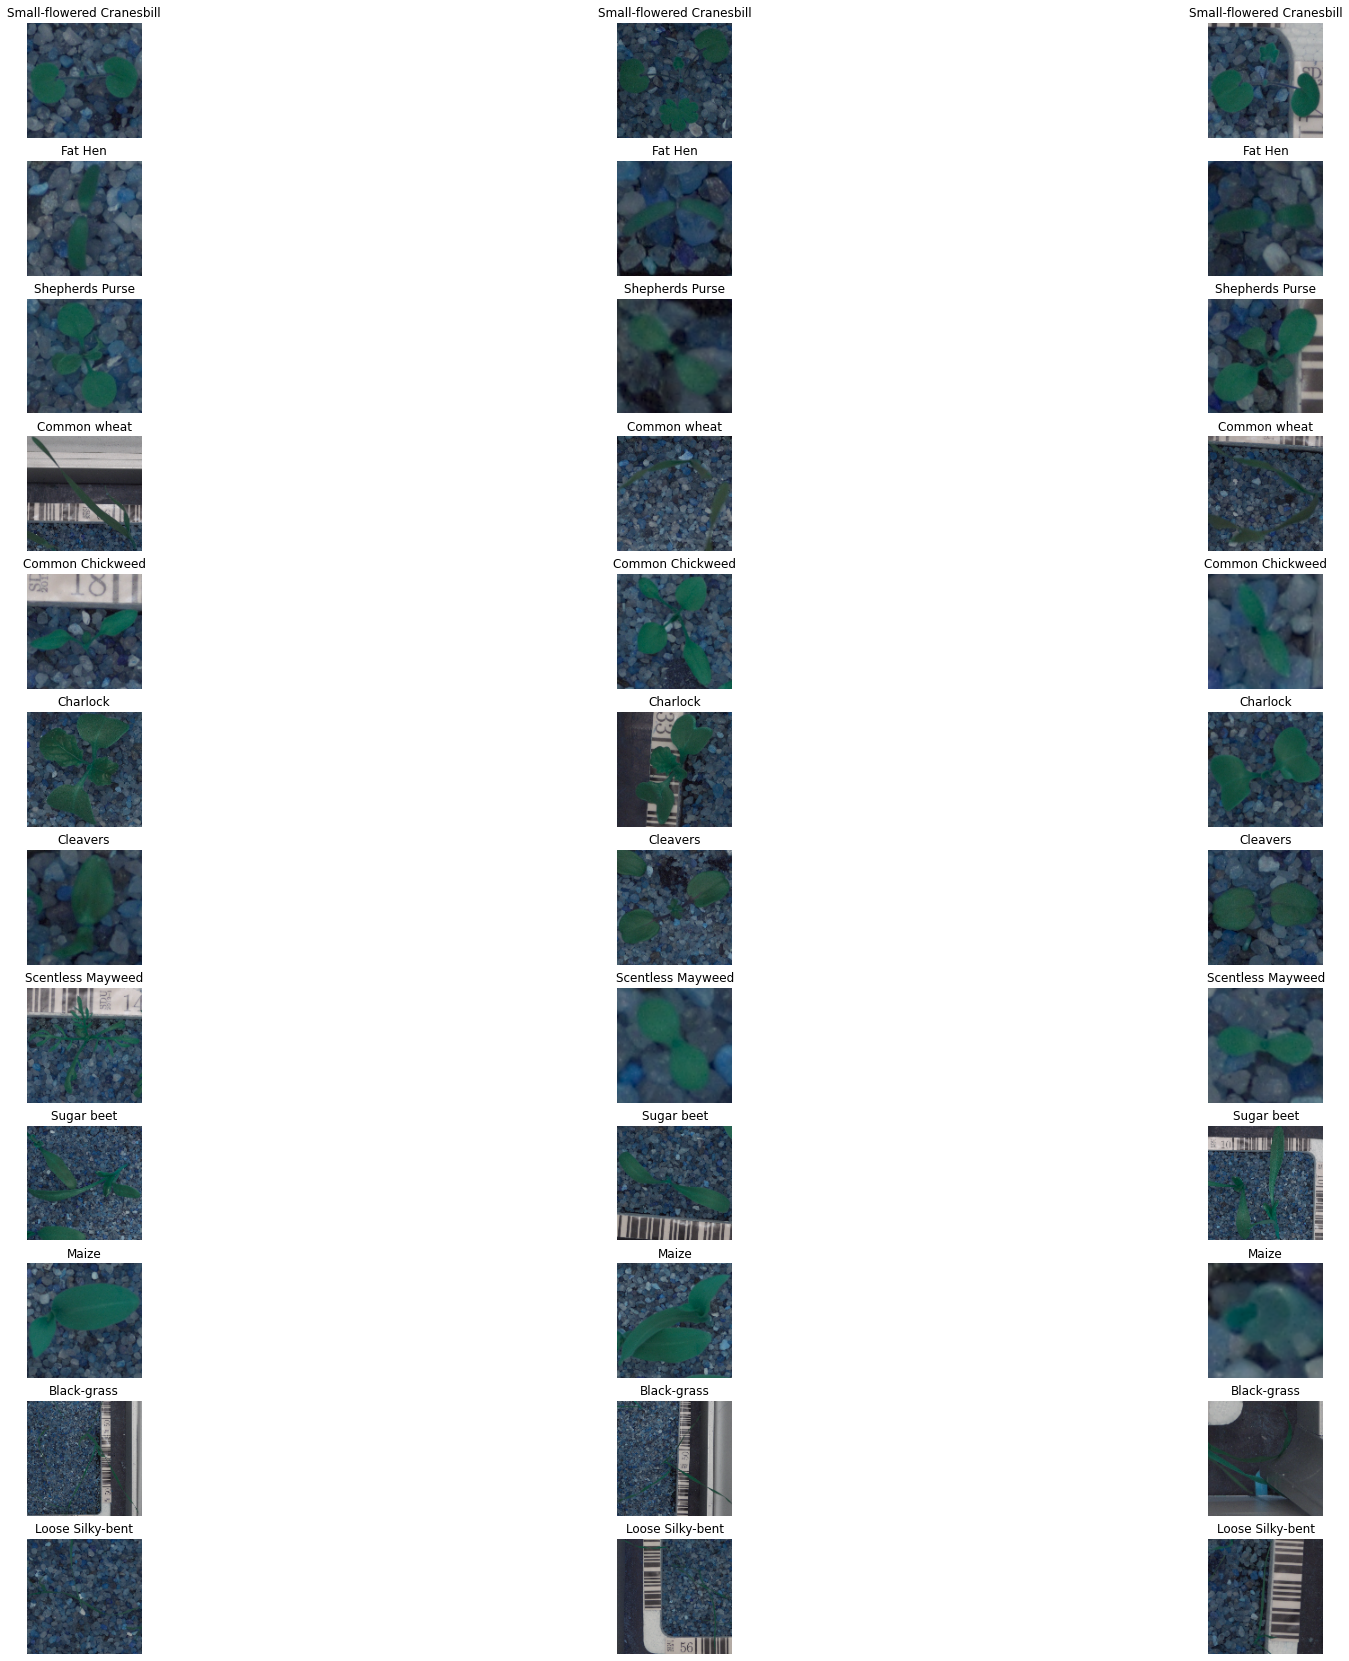

In [7]:
# visualize 3 random images from each seedling category

categories = lbl_data['Label'].unique()
d={ i:[] for i in categories}

for i in categories:
    d[i] = lbl_data.index[lbl_data['Label'] == i].tolist()
    
fig = plt.figure(figsize = (30,30))
t=0 
for category in d:
  count=0
  for i in d[category]:
    if count <3:
     ax = fig.add_subplot(12, 3, t+1)
     t=t+1
     plt.autoscale
     plt.imshow(img_data[i])
     plt.title(lbl_data['Label'][i])
     plt.axis('off')
     count= count+1
plt.show()

#### **Observations**
- There are 12 categories of plant seedlings.
- Each image is colored and with 128x128 pixels.
- Image clarity and quality is not consistent across all images.
- There are various other distracting objects in the background.

## **Exploratory Data Analysis**

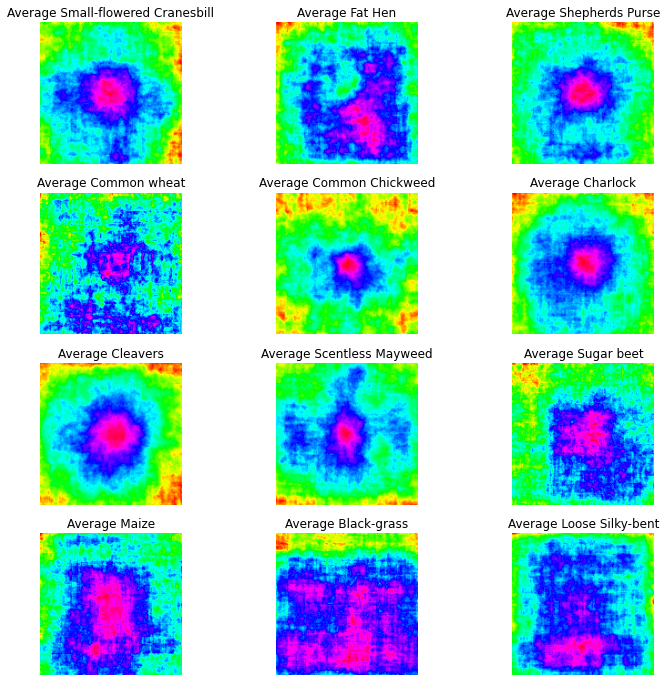

In [8]:
# creating a user defined function to calculate and plot the mean image of each category

def find_mean_img(full_mat):
    mean_img = np.mean(full_mat, axis=0)                                       # Taking the mean of pixel values for each category and storing in mean_img
    return mean_img

categories = lbl_data['Label'].unique()                                        # Storing all the unique labels
d={ i:[] for i in categories}                                                  # Here we are creating a dictionary with keys as unique categories and values as list for each category

for i in lbl_data.index:
#   img_gray = rgb2gray(img_data[i])
    img_gray = cv2.cvtColor(img_data[i], cv2.COLOR_BGR2GRAY)                     # convert image to grayscale
    d[lbl_data['Label'][i]].append(img_gray)                                     # Here we are appending each image of its category to its respective list in the dictionary

mean_img_list=[]
for i in d.keys():                                                             # Looping over each category from the keys in the dictionary and appeding the mean image of each category to the newly created list(mean_img_list)
  mean_img_list.append(find_mean_img(d[i]))

plt.subplots(figsize=(12,12))
for i in range(len(mean_img_list)):
    plt.subplot(4, 3, i+1, title='Average '+list(d.keys())[i])
    plt.imshow(mean_img_list[i], cmap='hsv_r')                                 # Here we are getting the image in different color to understand the difference between the mean image of all the 4 categories using cmap = hsv_r
    plt.axis('off')

#### **Observations**
- From the above average plots we can observe how the plant seedlings of different categories differ from each other.
- However I'm not sure how helpful this is as there is too much noise and inconsistency in the original images to identify unique features.

## **Data Preprocessing**

Small-flowered Cranesbill


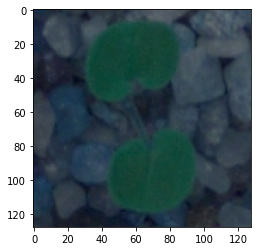

In [9]:
# visualize sample image before preprocessing
i = 150
image = img_data[i]
print(lbl_data.iloc[i]['Label'])
plt.imshow(image);

In [10]:
# apply Gaussian blurring
for idx, img in enumerate(img_data):
  img_data[idx] = cv2.GaussianBlur(img, (5, 5), 0)

Small-flowered Cranesbill


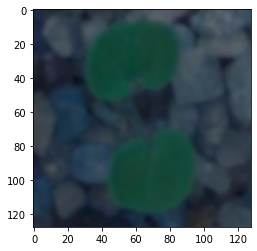

In [11]:
# visualize sample image after applying Gaussian blurring
i = 150
image_gb = img_data[i]
print(lbl_data.iloc[i]['Label'])
plt.imshow(image_gb);

In [12]:
# normalize the data
img_data = img_data.astype('float32')
img_data /= 255

Small-flowered Cranesbill


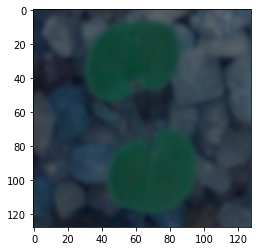

In [13]:
# visualize sample image after preprocessing
i = 150
image_gb = img_data[i]
print(lbl_data.iloc[i]['Label'])
plt.imshow(image_gb);

In [14]:
# split training set and testing set

X_train, X_test, y_train, y_test = train_test_split(img_data, lbl_data, test_size=0.2, random_state=1, stratify=lbl_data)

In [15]:
X_train.shape, X_test.shape   # check shape

((3800, 128, 128, 3), (950, 128, 128, 3))

In [16]:
y_train.shape, y_test.shape   # check shape

((3800, 1), (950, 1))

In [17]:
# reshape data into shapes compatible with Keras model

X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)

In [18]:
# encode the target variable

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_ohe = encoder.fit_transform(y_train)
y_test_ohe = encoder.fit_transform(y_test)

## **CNN Model Building & Evaluation**

### **Model 1**

In [19]:
from tensorflow.keras import backend
backend.clear_session()
# fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [20]:
# initialize model1
model1 = Sequential()

# adding first conv layer with 128 filters and kernel size 5x5, with ReLU activation and padding 'same' provides the output size same as the input size
model1.add(Conv2D(filters=128, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(128,128,3)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(256, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(12, activation="softmax"))

In [21]:
# printing the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

In [22]:
# taking Adam as an optimizer with learning rate 0.001
optimizer = Adam(lr=0.001)

# compiling the model with Adam as optimizer, categorical_crossentropy as loss function and accuracy as metrics
model1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fitting the model with 30 epochs and validation_split as 20%
history=model1.fit(X_train, y_train_ohe, epochs=30, batch_size=64, validation_split=0.20, callbacks=[es, mc]) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 2.4447 - accuracy: 0.1316
Epoch 1: val_accuracy improved from -inf to 0.18816, saving model to best_model.h5
48/48 [==============================] - 18s 240ms/step - loss: 2.4447 - accuracy: 0.1316 - val_loss: 2.4194 - val_accuracy: 0.1882
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 2.2486 - accuracy: 0.2372
Epoch 2: val_accuracy improved from 0.18816 to 0.43816, saving model to best_model.h5
48/48 [==============================] - 9s 190ms/step - loss: 2.2486 - accuracy: 0.2372 - val_loss: 1.8363 - val_accuracy: 0.4382
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 1.8338 - accuracy: 0.3704
Epoch 3: val_accuracy improved from 0.43816 to 0.48816, saving model to best_model.h5
48/48 [==============================] - 9s 191ms/step - loss: 1.8338 - accuracy: 0.3704 - val_loss: 1.6170 - val_accuracy: 0.4882
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 1

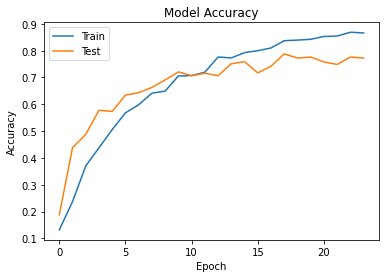

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
model1.evaluate(X_test,(y_test_ohe))

30/30 [==============================] - 2s 52ms/step - loss: 0.9484 - accuracy: 0.7442


[0.9484051465988159, 0.7442105412483215]

In [25]:
# Test Prediction 
y_test_pred_ln1 = model1.predict(X_test)
y_test_pred_classes_ln1 = np.argmax(y_test_pred_ln1, axis=1)
normal_y_test = np.argmax(y_test_ohe, axis=1)

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score((normal_y_test), y_test_pred_classes_ln1)

0.7442105263157894

In [27]:
from sklearn.metrics import precision_recall_fscore_support  
p=precision_recall_fscore_support(normal_y_test, y_test_pred_classes_ln1, average=None,labels=list(np.unique(normal_y_test)))
print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2]))

 Precision is [0.35714286 0.85       0.85416667 0.76       0.95454545 0.79761905
 0.67924528 0.78571429 0.664      0.59459459 0.89795918 0.67532468]
 Recall is [0.18867925 0.87179487 0.70689655 0.93442623 0.47727273 0.70526316
 0.82442748 0.75       0.80582524 0.47826087 0.88888889 0.67532468] 
 f_beta Score is [0.24691358 0.86075949 0.77358491 0.83823529 0.63636364 0.74860335
 0.74482759 0.76744186 0.72807018 0.53012048 0.89340102 0.67532468]


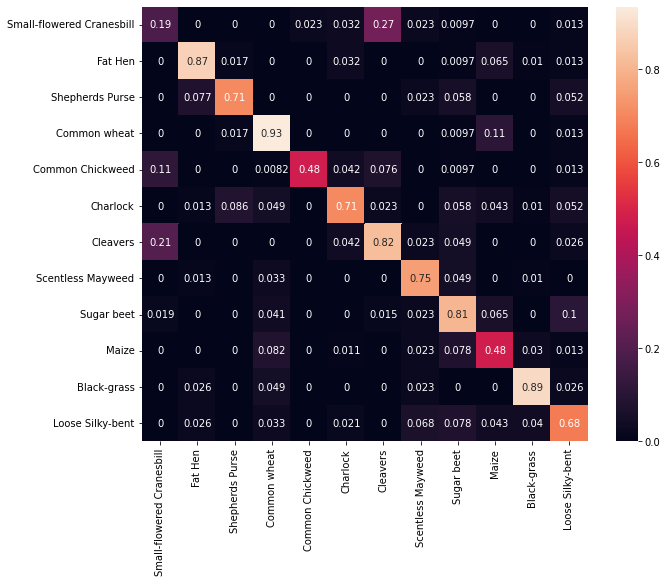

In [28]:
cf_matrix = confusion_matrix(normal_y_test, y_test_pred_classes_ln1)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_n1, xticklabels=categories, yticklabels=categories, annot=True)

#### **Observations**
- Accuracy score on the testing set is about 74% which is reasonably good. 
- Looks like model is confused between Cleavers and Small-flowered Cranesbill.
- Lets try improving the model performance by adding more convolution and dense layers. 

### **Model 2 - With Additional Layers**

In [29]:
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [30]:
# initialize model2 with additional convolution and dense layers
model2 = Sequential()
# adding first conv layer with 128 filters and kernel size 5x5 , with ReLU activation and padding 'same' provides the output size same as the input size
model2.add(Conv2D(filters=128, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(128,128,3)))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=64, kernel_size=(5,5), padding='Same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(12, activation="softmax"))

In [31]:
# taking Adam as an optimizer with learning rate 0.001
optimizer = Adam(lr=0.001)
# compiling the model with Adam as optimizer, categorical_crossentropy as loss function and accuracy as metrics
model2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Fitting the model with 30 epochs and validation_split as 20%
history=model2.fit(X_train, y_train_ohe, epochs=30, batch_size=64, validation_split=0.20, callbacks=[es, mc]) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 2.4498 - accuracy: 0.1122
Epoch 1: val_accuracy improved from -inf to 0.14079, saving model to best_model.h5
48/48 [==============================] - 16s 273ms/step - loss: 2.4498 - accuracy: 0.1122 - val_loss: 2.4401 - val_accuracy: 0.1408
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 2.4302 - accuracy: 0.1237
Epoch 2: val_accuracy did not improve from 0.14079
48/48 [==============================] - 10s 210ms/step - loss: 2.4302 - accuracy: 0.1237 - val_loss: 2.4059 - val_accuracy: 0.1408
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 2.4086 - accuracy: 0.1451
Epoch 3: val_accuracy improved from 0.14079 to 0.28947, saving model to best_model.h5
48/48 [==============================] - 10s 212ms/step - loss: 2.4086 - accuracy: 0.1451 - val_loss: 2.3054 - val_accuracy: 0.2895
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 2.2136 - accuracy: 0.2438
Epoch 4:

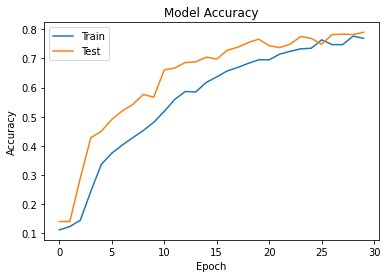

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
model2.evaluate(X_test, y_test_ohe)

30/30 [==============================] - 1s 48ms/step - loss: 0.7612 - accuracy: 0.7558


[0.7611504793167114, 0.7557894587516785]

In [40]:
# Test Prediction 
y_test_pred_ln2 = model2.predict(X_test)
y_test_pred_classes_ln2 = np.argmax(y_test_pred_ln2, axis=1)
normal_y_test = np.argmax(y_test_ohe, axis=1)

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score((normal_y_test), y_test_pred_classes_ln2)

0.7557894736842106

In [42]:
from sklearn.metrics import precision_recall_fscore_support  
p=precision_recall_fscore_support(normal_y_test, y_test_pred_classes_ln2, average=None,labels=list(np.unique(normal_y_test)))
print(" Precision is {}\n Recall is {} \n f_beta Score is {}".format(p[0],p[1],p[2]))

 Precision is [0.         0.92537313 0.76190476 0.87704918 0.72727273 0.8125
 0.58937198 0.76470588 0.73636364 0.67647059 0.83478261 0.72972973]
 Recall is [0.         0.79487179 0.82758621 0.87704918 0.18181818 0.82105263
 0.93129771 0.88636364 0.78640777 0.5        0.96969697 0.7012987 ] 
 f_beta Score is [0.         0.85517241 0.79338843 0.87704918 0.29090909 0.81675393
 0.72189349 0.82105263 0.76056338 0.575      0.89719626 0.71523179]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


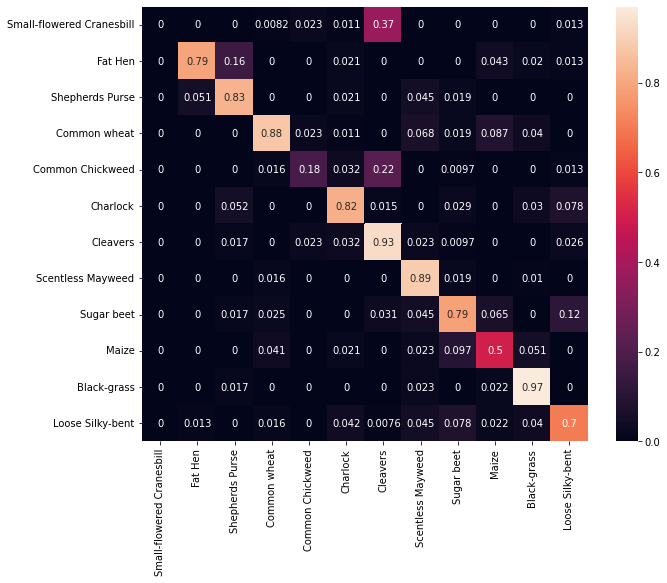

In [43]:
cf_matrix2 = confusion_matrix(normal_y_test, y_test_pred_classes_ln2)

# Confusion matrix normalized per category true value
cf_matrix_n2 = cf_matrix2/np.sum(cf_matrix2, axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix_n2, xticklabels=categories, yticklabels=categories, annot=True)

#### **Observations**
- There was marginal improvement in the accuracy score at 76%. 
- Model is even more confused between Cleavers and Small-flowered Cranesbill.
- Similarly model is showing increased confusion between many other pairs of plant seedlings. 
- Which could be due to more noise and overfitting.

## **Conclusion**
- Simpler Model 1 is giving slightly better performance. Which in my experience has been the case as more layers, filters, and neurons don't necessarily translate to better performance. 
- There is still scope for improvement in the test accuracy of this model. Different architectures could be tried and in addition hyperparameter tuning could lead to optimized performance. 